# Goddard problem

In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Research/logiciels/dev/control-toolbox/BVP-DAE/julia`


In [2]:
using JSON
import Plots: plot, plot!, Plots

## BVP-DAE

In [11]:
struct GoddardBVPSol

    t
    h
    v
    m
    ph
    pv
    pm
    u
    tf
    obj

    function GoddardBVPSol()

        data = JSON.parsefile("../python/Goddard/results_goddard_primal_dual.json")

        t  =  data["t"]
        u  =  data["z"][1, :][1]
        h  =  data["xp"][1, :][1]
        v  =  data["xp"][2, :][1]
        m  =  data["xp"][3, :][1]
        ph = -data["xp"][5, :][1]
        pv = -data["xp"][6, :][1]
        pm = -data["xp"][7, :][1]
        
        tf  = data["xp"][4, 1][1]
        obj = h[end]

        return new(t, h, v, m, ph, pv, pm, u, tf, obj)

    end

end

sol_bvp = GoddardBVPSol()

println("Final time:      ", sol_bvp.tf)
println("Objective value: ", sol_bvp.obj)

nothing

Final time:      0.2040494160682758
Objective value: 1.012717589749775


In [4]:
function plot(sol::GoddardBVPSol; kwargs...)

    t  = sol.t
    h  = sol.h
    v  = sol.v
    m  = sol.m
    u  = sol.u
    ph = sol.ph
    pv = sol.pv
    pm = sol.pm
    tf = sol.tf

    plt_h  = Plots.plot(t*tf, h;  label="h")
    plt_v  = Plots.plot(t*tf, v;  label="v")
    plt_m  = Plots.plot(t*tf, m;  label="m")
    plt_ph = Plots.plot(t*tf, ph; label="ph")
    plt_pv = Plots.plot(t*tf, pv; label="pv")
    plt_pm = Plots.plot(t*tf, pm; label="pm")
    plt_u  = Plots.plot(t*tf, u;  label="u")

    plt_state   = Plots.plot(plt_h,  plt_v,  plt_m;  layout=(3, 1))
    plt_costate = Plots.plot(plt_ph, plt_pv, plt_pm; layout=(3, 1))

    plt_xp = Plots.plot(plt_state, plt_costate; layout=(1, 2))

    layout = Plots.grid(2, 1, heights=[3/4, 1/4])
    return Plots.plot(plt_xp, plt_u; layout=layout, kwargs...)

end

function plot!(p::Plots.Plot, sol::GoddardBVPSol; kwargs...)
    
    t  = sol.t
    h  = sol.h
    v  = sol.v
    m  = sol.m
    u  = sol.u
    ph = sol.ph
    pv = sol.pv
    pm = sol.pm
    tf = sol.tf

    Plots.plot!(p[1], t*tf, h;  label="h (BVP)", kwargs...)
    Plots.plot!(p[2], t*tf, v;  label="v (BVP)", kwargs...)
    Plots.plot!(p[3], t*tf, m;  label="m (BVP)", kwargs...)
    Plots.plot!(p[4], t*tf, ph; label="ph (BVP)", kwargs...)
    Plots.plot!(p[5], t*tf, pv; label="pv (BVP)", kwargs...)
    Plots.plot!(p[6], t*tf, pm; label="pm (BVP)", kwargs...)
    Plots.plot!(p[7], t*tf, u;  label="u (BVP)", kwargs...)

end
nothing

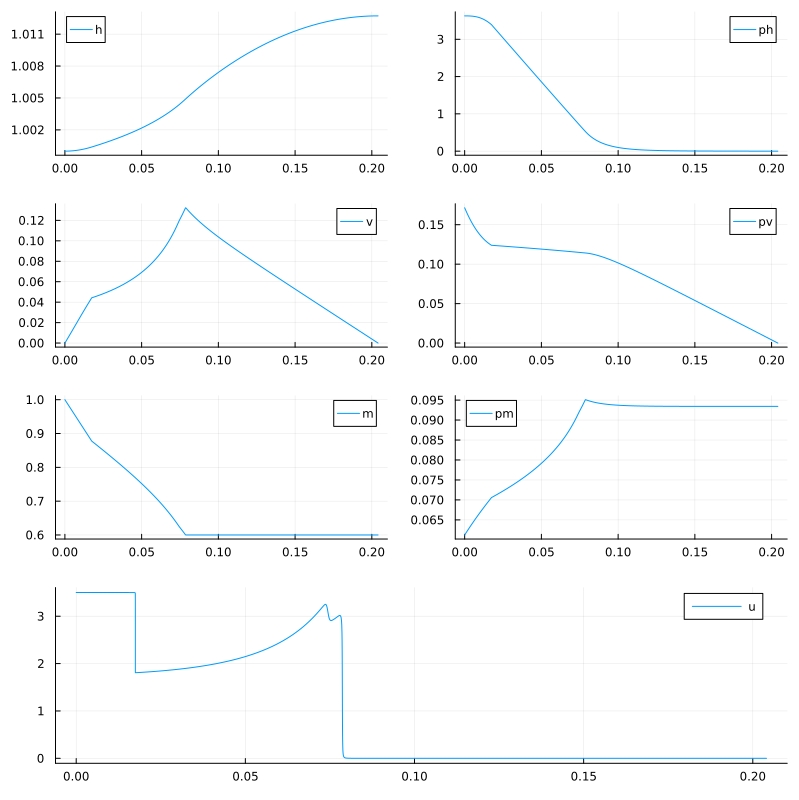

In [5]:
plt_bvp = plot(sol_bvp; size=(800, 800))

## Direct method

In [6]:
using OptimalControl

const t0 = 0      # initial time
const h0 = 1      # initial altitude
const v0 = 0      # initial speed
const m0 = 1      # initial mass
const mf = 0.6    # final mass to target
const Tmax = 3.5

@def ocp begin # definition of the optimal control problem

    tf ∈ R, variable
    t ∈ [ t0, tf ], time
    x = (h, v, m) ∈ R³, state
    u ∈ R, control

    x(t0) == [ h0, v0, m0 ]
    m(tf) == mf,         (1)
    0 ≤ u(t) ≤ Tmax
    h(t) ≥ h0
    q(h(t), v(t)) ≤ 0

    ẋ(t) == F0(h(t), v(t), m(t)) + u(t) * F1(h(t), v(t), m(t))

    h(tf) → max

end;

# Dynamics
const Cd = 310
const β = 500
const b = 2
const qmax = 10

d(h, v) = Cd * v^2 * exp(-β*(h - 1)) # drag force
q(h, v) = 20 * d(h, v) - qmax        # dynamic pressure

F0(h, v, m) = [ v, -d(h, v)/m - 1/h^2,  0 ]
F1(h, v, m) = [ 0,                1/m, -b ]

nothing

In [7]:
using NLPModelsIpopt
direct_sol = solve(ocp; grid_size=100, print_level=4)

Method = (:direct, :adnlp, :ipopt)
Total number of variables............................:      405
                     variables with only lower bounds:      101
                variables with lower and upper bounds:      101
                     variables with only upper bounds:        0
Total number of equality constraints.................:      304
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      101


Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:  -1.0127121101567500e+00   -1.0127121101567500e+00
Dual infeasibility......:   2.3529068461087494e-09    2.3529068461087494e-09
Constraint violation....:   1.7998724732848359e-10    3.0291541497362573e-10
Variable bound violation:   0.0000000000000000e+00    0

CTBase.OptimalControlSolution

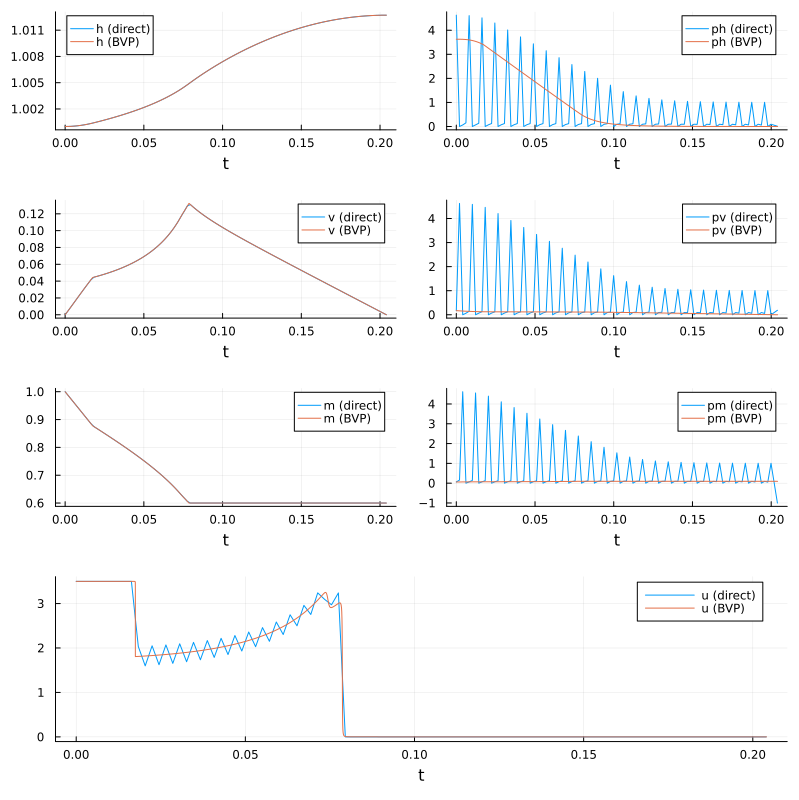

In [8]:
plt = plot(direct_sol, solution_label="(direct)", size=(800, 800))
plot!(plt, sol_bvp)

## Indirect method

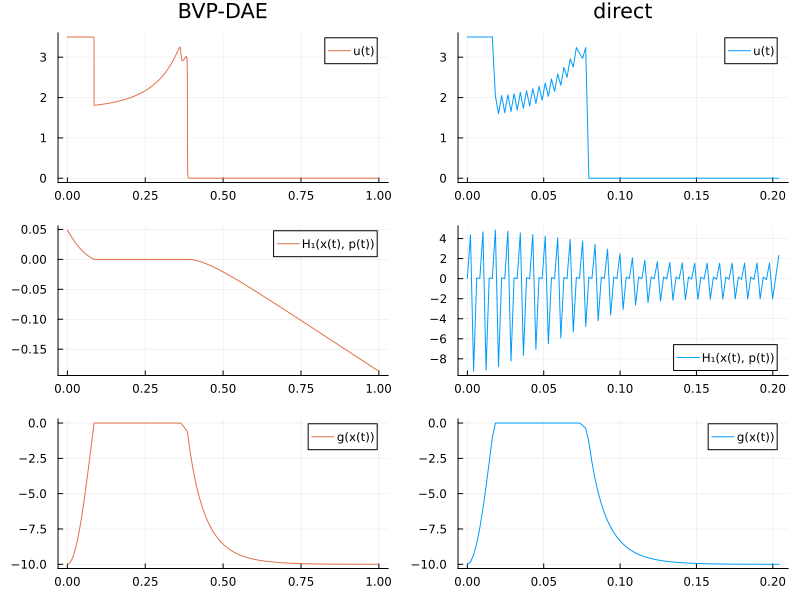

In [12]:
# info from direct

t = direct_sol.times
x = direct_sol.state
u = direct_sol.control
p = direct_sol.costate

H1 = Lift(x -> F1(x...))    # H1(x, p) = p' * F1(x)
φ(t) = H1(x(t), p(t))       # switching function
g(x) = q(x[1], x[2])        # q(h, v)

u_plot  = plot(t, u,     label = "u(t)",           color=1, title="direct")
H1_plot = plot(t, φ,     label = "H₁(x(t), p(t))", color=1)
g_plot  = plot(t, g ∘ x, label = "g(x(t))",        color=1)

plt_info_direct = plot(u_plot, H1_plot, g_plot; layout=(3,1))

# info from BVP-DAE
ts  = sol_bvp.t
hs  = sol_bvp.h
vs  = sol_bvp.v
ms  = sol_bvp.m
us  = sol_bvp.u
phs = sol_bvp.ph
pvs = sol_bvp.pv
pms = sol_bvp.pm
tf  = sol_bvp.tf

X = [ [h, v, m] for (h, v, m) ∈ zip(hs, vs, ms) ]
P = [ [ph, pv, pm] for (ph, pv, pm) ∈ zip(phs, pvs, pms) ]
U = us

H1_bvp = H1.(X, P)
g_bvp  = g.(X)

u_plot  = plot(ts, us,     label = "u(t)",           color=2, title="BVP-DAE")
H1_plot = plot(ts, H1_bvp, label = "H₁(x(t), p(t))", color=2)
g_plot  = plot(ts, g_bvp,  label = "g(x(t))",        color=2)

plt_info_bvp = plot(u_plot, H1_plot, g_plot;  layout=(3,1))

#
plot(plt_info_bvp, plt_info_direct; layout=(1, 2), size=(800, 600))
